# Objective

- The goal is to find out how much wind power would be generated every day

In [70]:
# importing libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [71]:
from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [72]:
from sklearn.metrics import mean_absolute_percentage_error

In [73]:
import warnings
warnings.filterwarnings('ignore')

In [74]:
df = pd.read_csv('wind_power.csv', parse_dates= ['dt'], index_col= 0)
df

,MW
dt,
2011-01-01 00:00:00,3416.00
2011-01-01 00:15:00,4755.00
2011-01-01 00:30:00,4939.00
2011-01-01 00:45:00,4939.00
2011-01-01 01:00:00,4998.00
...,...
2021-12-30 06:45:00,8140.31
2021-12-30 07:00:00,8162.33
2021-12-30 07:15:00,8405.11


In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 385566 entries, 2011-01-01 00:00:00 to 2021-12-30 07:45:00
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   MW      385566 non-null  float64
dtypes: float64(1)
memory usage: 5.9 MB


In [76]:
df.isnull().sum()

MW    0
dtype: int64

In [77]:
start_date = pd.to_datetime('2021-11-01')
new_df = df[start_date:]
new_df.head()

,MW
dt,
2021-11-01 00:00:00,12986.92
2021-11-01 00:15:00,6449.50
2021-11-01 00:30:00,6438.13
2021-11-01 00:45:00,6341.37
2021-11-01 01:00:00,6371.73


Text(0, 0.5, 'Power generated in MW')

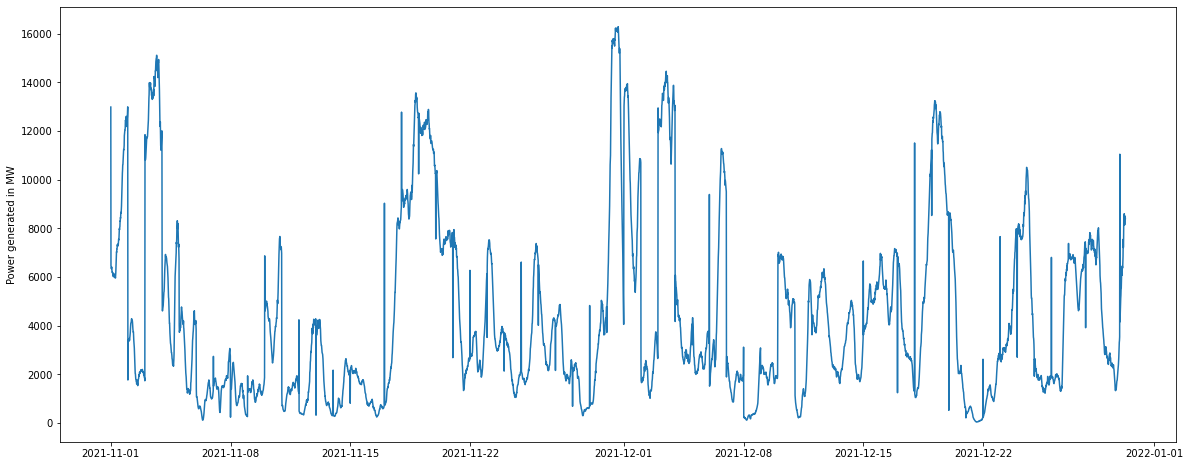

In [78]:
plt.figure(figsize= (20,8))
plt.plot(new_df)
plt.ylabel("Power generated in MW")

# Decomposing data to check trends and seasonality

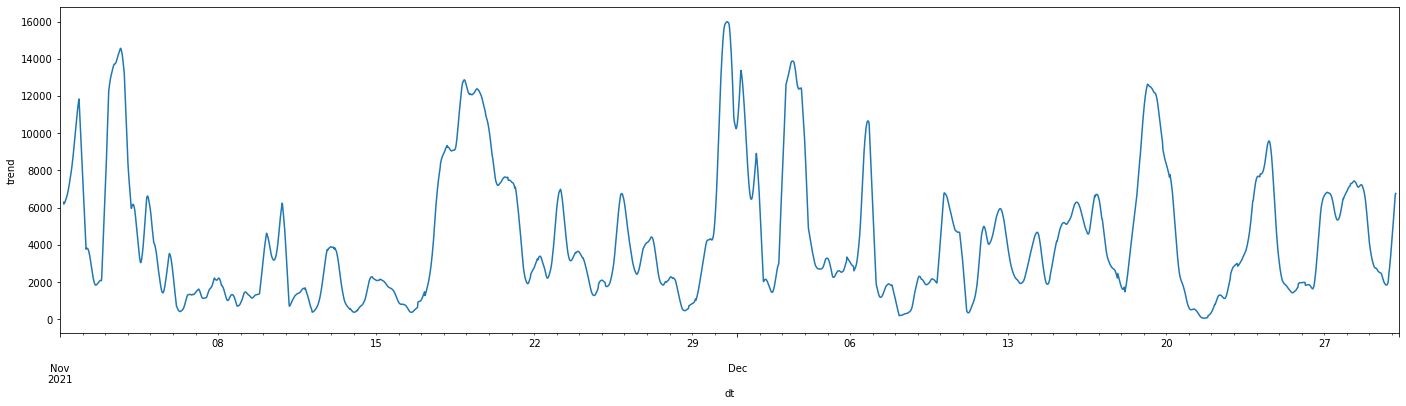

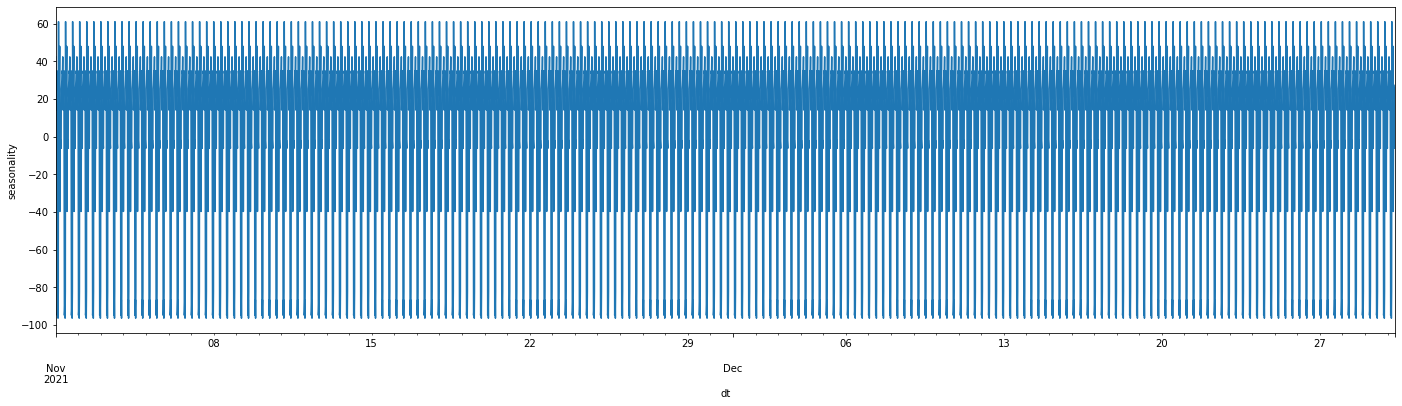

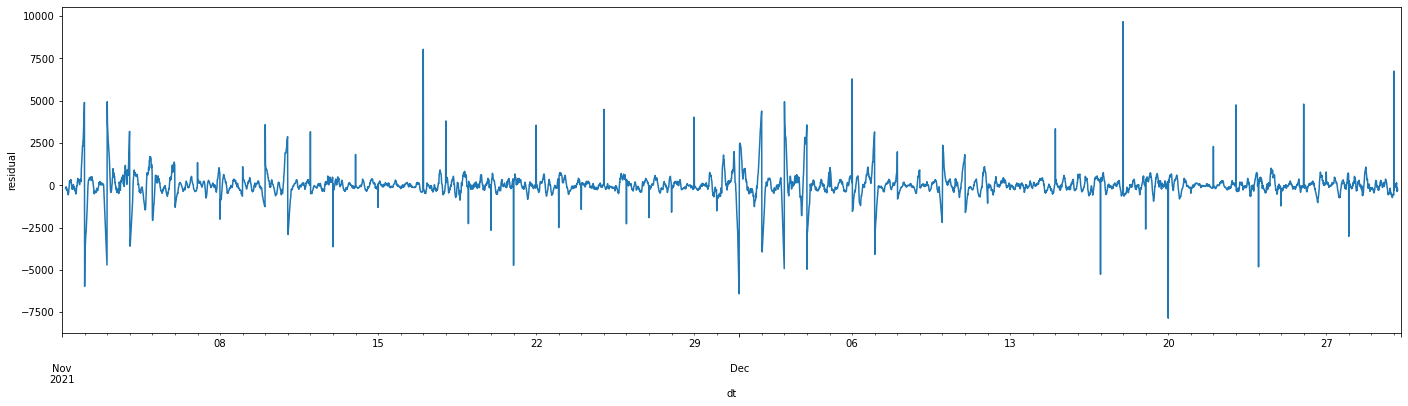

In [79]:
seasonality = seasonal_decompose(new_df, model = 'additive', period = 30)

plt.figure(figsize=(24,6))
seasonality.trend.plot(ylabel = 'trend')
plt.show()

plt.figure(figsize=(24,6))
seasonality.seasonal.plot(ylabel = 'seasonality')
plt.show()

plt.figure(figsize=(24,6))
seasonality.resid.plot(ylabel = 'residual')
plt.show()

# Readings of a Single Day

In [80]:
day_to_observe = pd.to_datetime('2021-12-01')
next_day = day_to_observe + pd.offsets.Day(1)
next_day

Timestamp('2021-12-02 00:00:00')

In [81]:
single_day = df[day_to_observe:next_day-pd.Timedelta('15min')]
single_day

,MW
dt,
2021-12-01 00:00:00,10712.41
2021-12-01 00:15:00,13036.81
2021-12-01 00:30:00,13278.28
2021-12-01 00:45:00,13410.89
2021-12-01 01:00:00,13435.42
...,...
2021-12-01 22:45:00,10796.89
2021-12-01 23:00:00,10829.83
2021-12-01 23:15:00,10840.73


Text(0.5, 1.0, 'Power Generation ')

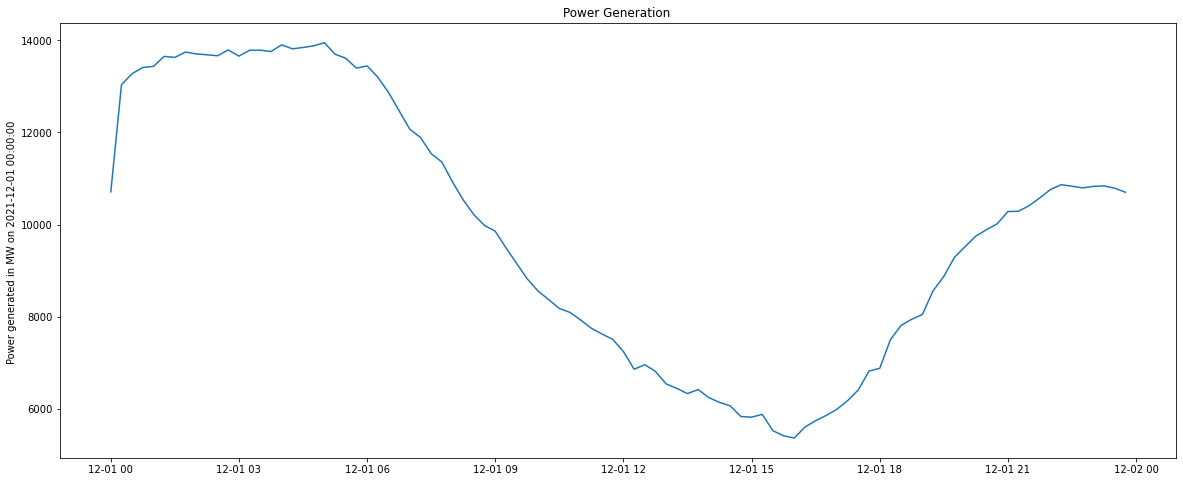

In [82]:
plt.figure(figsize= (20,8))
plt.plot(single_day)
plt.ylabel(f"Power generated in MW on {day_to_observe} ")
plt.title("Power Generation ")

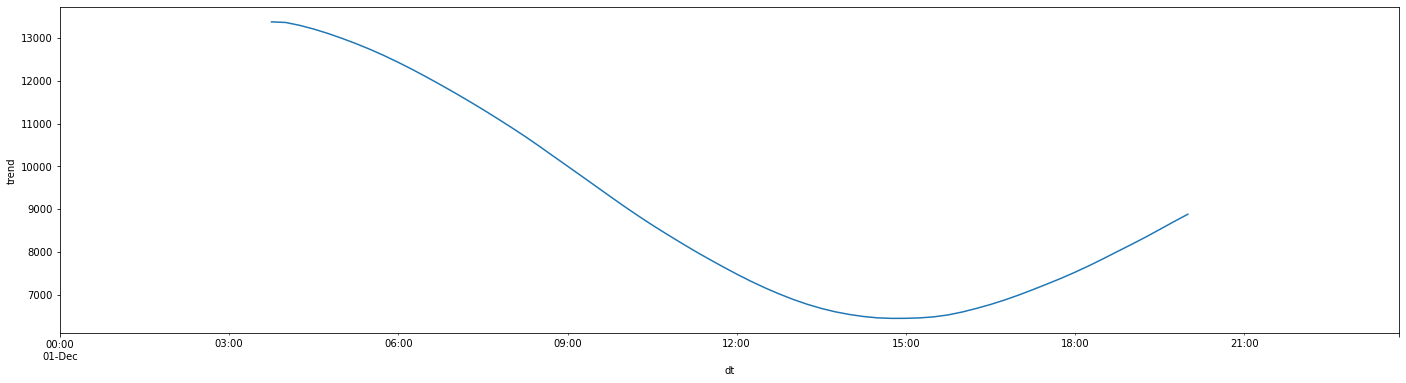

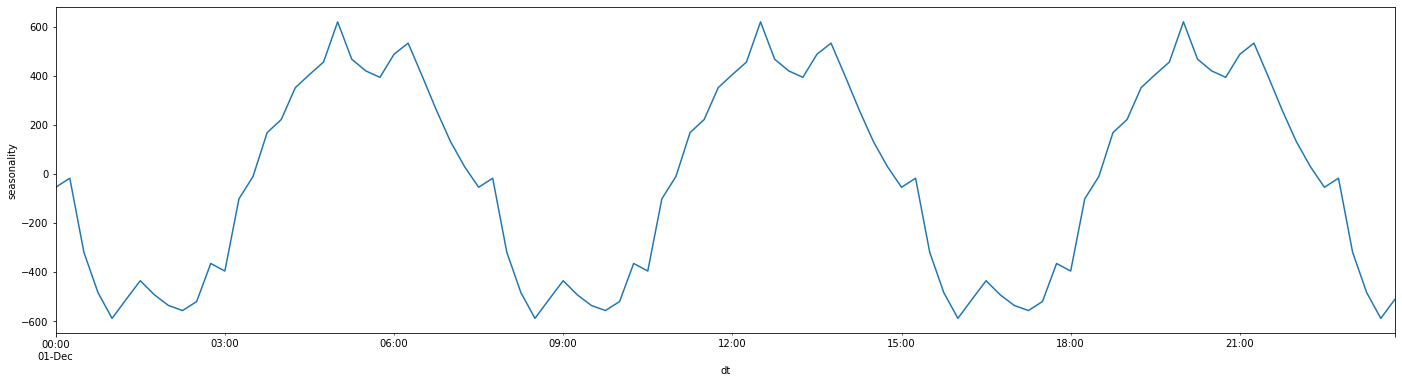

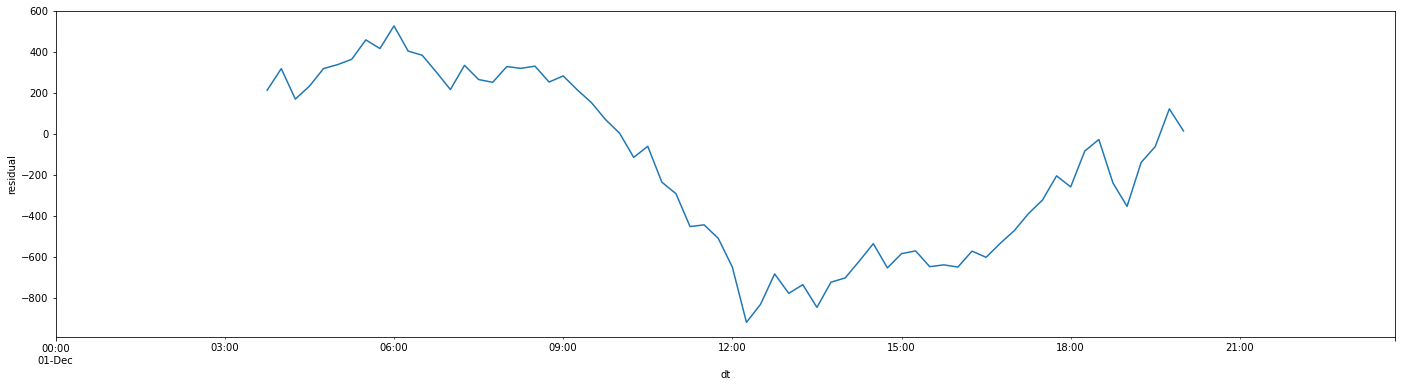

In [83]:
seasonality = seasonal_decompose(single_day, model = 'additive', period = 30)

plt.figure(figsize=(24,6))
seasonality.trend.plot(ylabel = 'trend')
plt.show()

plt.figure(figsize=(24,6))
seasonality.seasonal.plot(ylabel = 'seasonality')
plt.show()

plt.figure(figsize=(24,6))
seasonality.resid.plot(ylabel = 'residual')
plt.show()

There is continuous upward and downward trend in the data.

Seasonality graph shows that the series repeats after 6 hours(24 timesteps).

## Converting into non-stationary series

In [38]:
new_df['first_diff'] = new_df['MW'].diff(periods = 1)

In [39]:
def adf_test(series):
    result = adfuller(series)
    print(f'ADF Statistics: {result[0]}')
    print(f'p value: {result[1]}')
    if result[1] <= 0.05:
        print('Reject Null Hypothesis. Data has no unit root and is stationary')
    else:
        print('weak evidence against null hypothesis, time series has a unit root indicating it is a non-stationary')

In [42]:
adf_test(new_df.first_diff.dropna())

ADF Statistics: -21.422790602264552
p value: 0.0
Reject Null Hypothesis. Data has no unit root and is stationary


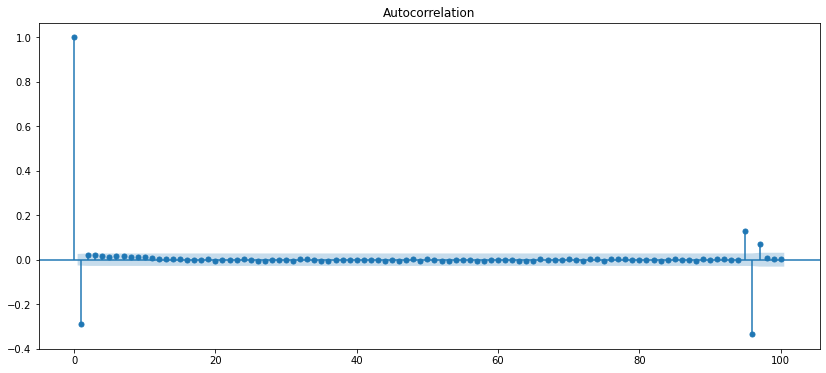

In [43]:
fig, ax = plt.subplots(figsize = (14,6))
acf = plot_acf(new_df.first_diff.dropna(), ax = ax, lags = 100)

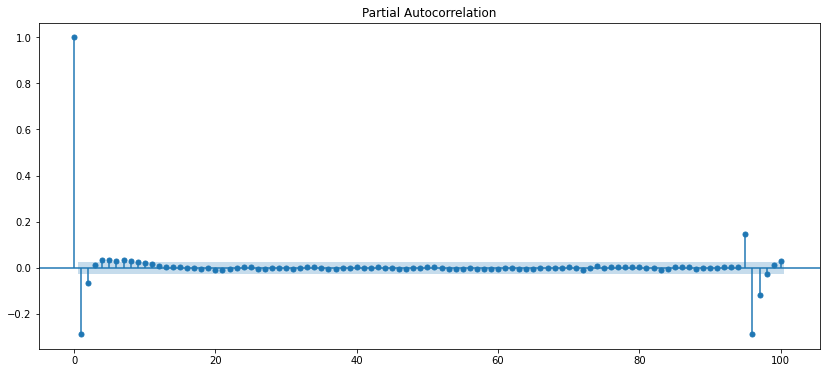

In [49]:
fig, ax = plt.subplots(figsize = (14,6))
acf = plot_pacf(new_df.first_diff.dropna(), ax = ax, lags = 100)

In [19]:
len(pd.date_range(start = pd.to_datetime('2021-11-01 00:00:00'),
                 end = pd.to_datetime('2021-12-30 07:45:00'), freq = '15min'))

5696

In [44]:
new_df

,MW,first_diff
dt,,
2021-11-01 00:00:00,12986.92,NaN
2021-11-01 00:15:00,6449.50,-6537.42
2021-11-01 00:30:00,6438.13,-11.37
2021-11-01 00:45:00,6341.37,-96.76
2021-11-01 01:00:00,6371.73,30.36
...,...,...
2021-12-30 06:45:00,8140.31,-272.57
2021-12-30 07:00:00,8162.33,22.02
2021-12-30 07:15:00,8405.11,242.78


# Splitting data into train and test set

In [45]:
train_end = pd.to_datetime('2021-12-26') - pd.Timedelta('15min')
train_end

Timestamp('2021-12-25 23:45:00')

In [60]:
train_data = new_df[:train_end]
train_data

,MW,first_diff
dt,,
2021-11-01 00:00:00,12986.92,NaN
2021-11-01 00:15:00,6449.50,-6537.42
2021-11-01 00:30:00,6438.13,-11.37
2021-11-01 00:45:00,6341.37,-96.76
2021-11-01 01:00:00,6371.73,30.36
...,...,...
2021-12-25 22:45:00,1935.79,9.60
2021-12-25 23:00:00,1908.07,-27.72
2021-12-25 23:15:00,1929.73,21.66


In [47]:
test_data = new_df[train_end + pd.Timedelta('15min'):]
test_data.head()

,MW,first_diff
dt,,
2021-12-26 00:00:00,6806.12,4916.81
2021-12-26 00:15:00,1998.78,-4807.34
2021-12-26 00:30:00,1850.48,-148.30
2021-12-26 00:45:00,1844.30,-6.18
2021-12-26 01:00:00,1909.84,65.54


In [48]:
len(train_data), len(test_data)

(5280, 416)

In [50]:
model = ARIMA(train_data.MW, order = (1,1,1)).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                     MW   No. Observations:                 5280
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -41150.058
Date:                Wed, 18 May 2022   AIC                          82306.117
Time:                        09:49:10   BIC                          82325.831
Sample:                    11-01-2021   HQIC                         82313.007
                         - 12-25-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1241      0.025     -4.915      0.000      -0.174      -0.075
ma.L1         -0.1776      0.026     -6.868      0.000      -0.228      -0.127
sigma2      3.394e+05    792.738    428.187      0.000    3.38e+05    3.41e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.86   Jarque-Bera (JB):           4394824.67
Prob(Q):                              0.35   Prob(JB):                         0.00
Heteroskedasticity (H):               0.81   Skew:                            -0.45
Prob(H) (two-sided):                  0.00   Kurtosis:                       144.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**The p < [z] for AR and MA terms are < 0.05. So all considered terms are significant.**

In [51]:
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

In [57]:
prediction = model.predict(start = pred_start_date, end = pred_end_date)
prediction 

2021-12-26 00:00:00    1891.665662
2021-12-26 00:15:00    1891.373355
2021-12-26 00:30:00    1891.409627
2021-12-26 00:45:00    1891.405126
2021-12-26 01:00:00    1891.405684
                          ...     
2021-12-30 06:45:00    1891.405623
2021-12-30 07:00:00    1891.405623
2021-12-30 07:15:00    1891.405623
2021-12-30 07:30:00    1891.405623
2021-12-30 07:45:00    1891.405623
Freq: 15T, Name: predicted_mean, Length: 416, dtype: float64

<AxesSubplot:xlabel='dt'>

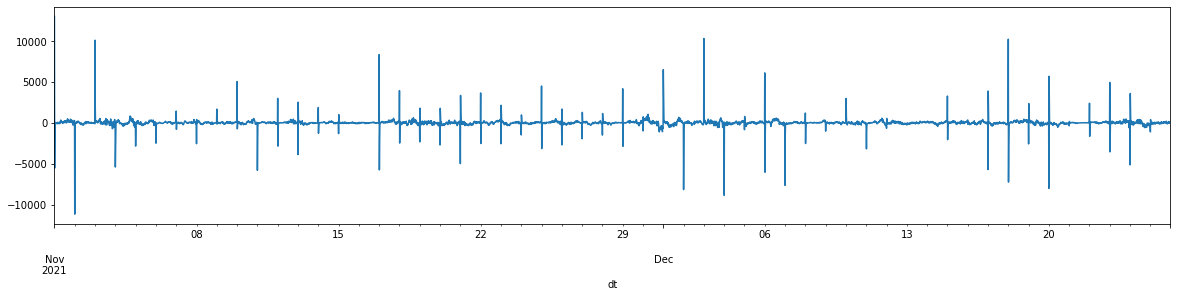

In [53]:
residuals = test_data.MW - prediction

fig, ax = plt.subplots(figsize = (20,4))
model.resid.plot(ax=ax)

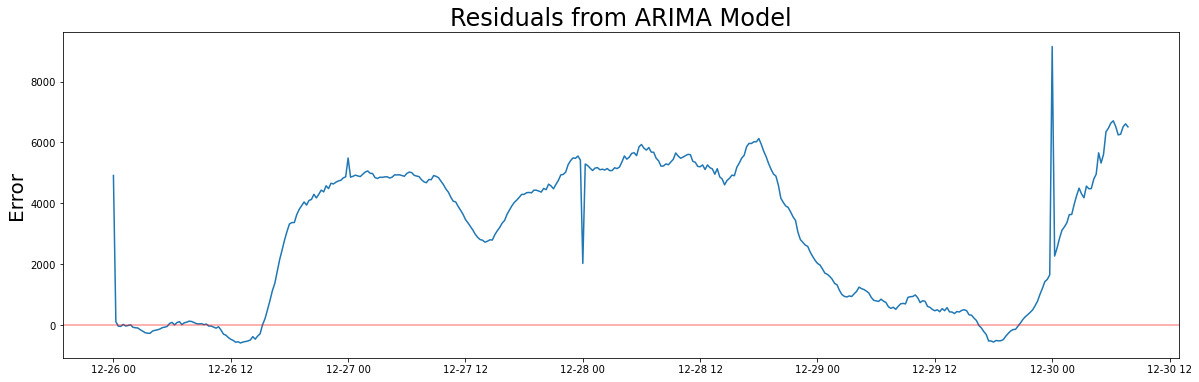

In [54]:
plt.figure(figsize=(20,6))
plt.plot(residuals)
plt.title('Residuals from ARIMA Model', fontsize=24)
plt.ylabel('Error', fontsize=20)
plt.axhline(0, color='r', alpha=0.4)

The residuals are very high to even consider the model.

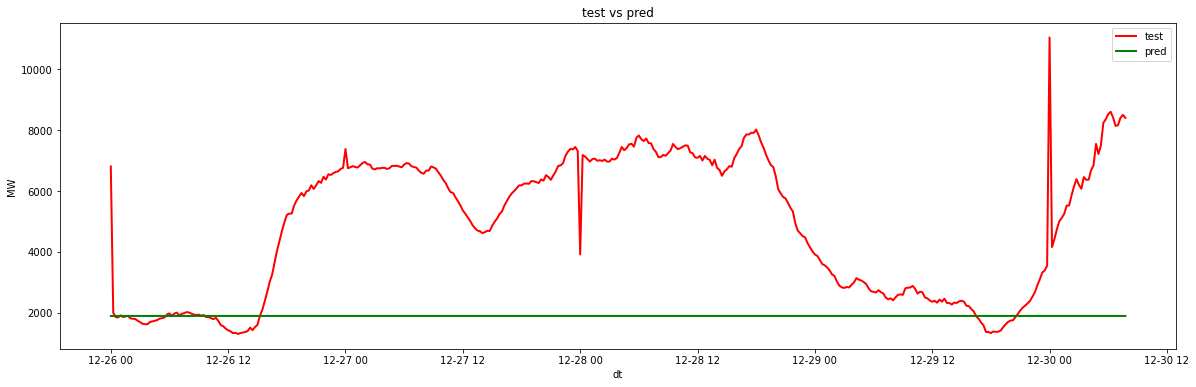

In [55]:
plt.figure(figsize=(20,6))
sns.lineplot(data=test_data,x=test_data.index,y=test_data.MW,lw=2,color='red')
sns.lineplot(x=prediction.index,y=prediction.values,lw=2,color='green')
plt.title("test vs pred")
plt.legend(['test','pred'])

- Since the MA term is 1 ,we can only make a single accurate prediction into the future.

- This explains the reason behind the model predicting the forested values to be the mean value and thereby error being too high.

In [59]:
mape = mean_absolute_percentage_error(test_data.MW, prediction.values )
mape

0.5138904520917085

# Making rolling predictions

In [61]:
predictions_rolling = pd.Series(dtype = np.float64)

for end_date in test_data.index:
    
    train_data = new_df[:end_date - pd.Timedelta('15min')]
    
    model = ARIMA(train_data.MW, order = (1,1,1)).fit()
    
    pred = model.predict(end_date)
    
    predictions_rolling[end_date] = pred[end_date]

In [62]:
rolling_residuals = test_data.MW - predictions_rolling
rolling_residuals[:2]

dt
2021-12-26 00:00:00    4914.454338
2021-12-26 00:15:00   -3323.750316
dtype: float64

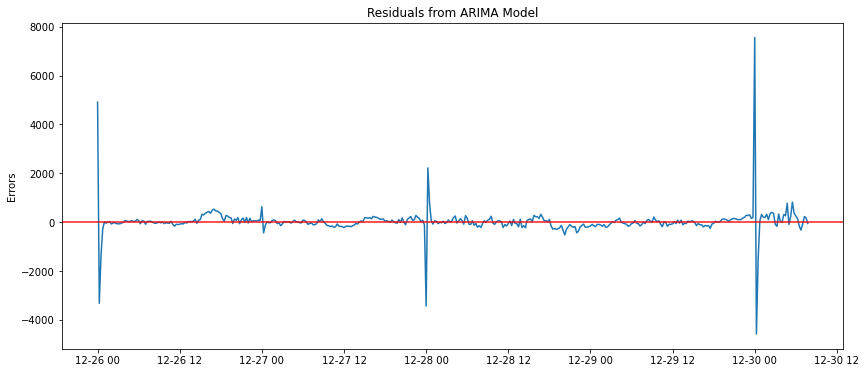

In [64]:
plt.figure(figsize=(14,6))
plt.plot(rolling_residuals)
plt.axhline(rolling_residuals.mean(),color='r',alpha=0.9,label='mean')
plt.title("Residuals from ARIMA Model");
plt.ylabel("Errors");

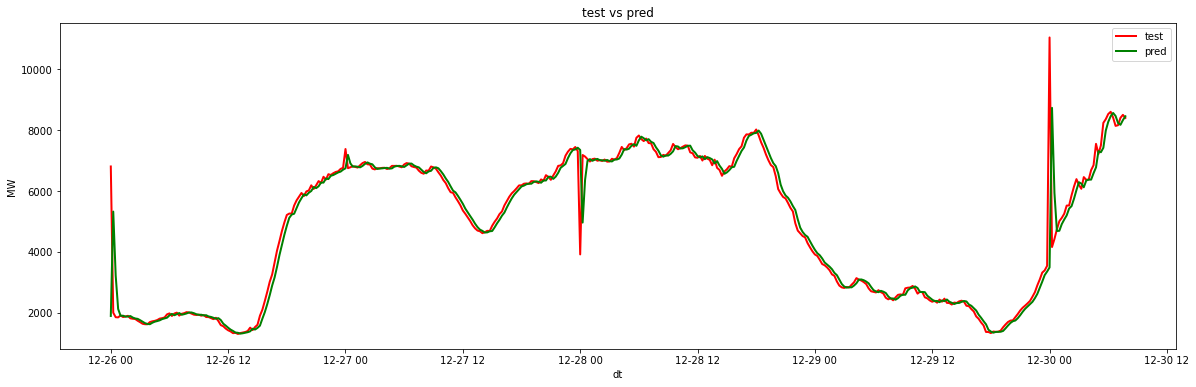

In [67]:
plt.figure(figsize=(20,6))
sns.lineplot(data=test_data,x=test_data.index,y=test_data.MW,lw=2,color='red')
sns.lineplot(x=predictions_rolling.index,y=predictions_rolling.values,lw=2,color='green')
plt.title("test vs pred")
plt.legend(['test','pred'])

In [68]:
mape = mean_absolute_percentage_error(test_data.MW, predictions_rolling.values )
mape

0.04544989602579418

**mean absolute percentage error:4.54**